<a href="https://colab.research.google.com/github/vishalgimhan/NLP-Projects/blob/main/Twitter_Sentiment_Analysis_%26_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade scikit-learn

In [ ]:
#!pip install ntscraper

In [ ]:
#!pip install nltk

In [ ]:
#!pip install spacy

In [ ]:
#!pip install demoji

In [ ]:
#from ntscraper import Nitter #To scrape Twitter data

import pprint #To print scraped data
import pandas as pd
import numpy as np
from datetime import datetime
import dateutil.parser

import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('vader_lexicon')
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
import spacy
#import demoji
#demoji.download_codes()
from nltk import word_tokenize

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split #Data testing
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XG
import pickle

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Extraction

In [ ]:
#scraper = Nitter(log_level = 1, skip_instance_check = False)

In [ ]:
#tweets = scraper.get_tweets("Taylor Swift", mode="term", number=10000, language="en")

#search term
#mode - user -> username, hashtag -> for hashtags
#number - number of tweets
#since -> start date
#untill -> end date

In [ ]:
# Create a pretty printer object
pp = pprint.PrettyPrinter(indent=4)

In [ ]:
# Use the pretty printer to print the data
#pp.pprint(tweets)

In [ ]:
#Look at the key values
#tweets.keys()

In [ ]:
#tweets['tweets'][0]

In [ ]:
#Get user info
#elon_info = scraper.get_profile_info(username="elonmusk")

In [ ]:
#pp.pprint(elon_info)

In [ ]:
# data = {
#     'link':[],
#     'text':[],
#     'user':[],
#     'likes':[],
#     'quotes':[],
#     'retweets':[],
#     'comments':[]
# }

# for tweet in tweets['tweets']:
#   data['link'].append(tweet['link'])
#   data['text'].append(tweet['text'])
#   data['user'].append(tweet['user']['name']) #name is inside user
#   data['likes'].append(tweet['stats']['likes'])
#   data['quotes'].append(tweet['stats']['quotes'])
#   data['retweets'].append(tweet['stats']['retweets'])
#   data['comments'].append(tweet['stats']['comments'])



In [ ]:
#data

In [ ]:
#Create a dataframe
# df = pd.DataFrame(data)
# df.head()

In [ ]:
def create_tweets_dataset(username, no_of_tweets):
  scraper = Nitter()
  tweets = scraper.get_tweets(username, mode="user", number=no_of_tweets)

  data = {
    'link':[],
    'text':[],
    'user':[],
    'likes':[],
    'quotes':[],
    'retweets':[],
    'comments':[]
  }

  for tweet in tweets['tweets']:
    data['link'].append(tweet['link'])
    data['text'].append(tweet['text'])
    data['user'].append(tweet['user']['name']) #name is inside user
    data['likes'].append(tweet['stats']['likes'])
    data['quotes'].append(tweet['stats']['quotes'])
    data['retweets'].append(tweet['stats']['retweets'])
    data['comments'].append(tweet['stats']['comments'])

  df = pd.DataFrame(data)

In [ ]:
#df.to_csv("TwiiterLiveData.csv")

Kaggle Dataset

In [ ]:
#configure the pathe of Kaggle .json file
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d gpreda/elon-musk-tweets

Dataset URL: https://www.kaggle.com/datasets/gpreda/elon-musk-tweets
License(s): CC0-1.0
  0% 0.00/369k [00:00<?, ?B/s]
100% 369k/369k [00:00<00:00, 72.3MB/s]


In [ ]:
#Extracting the compressed dataset

from zipfile import ZipFile
twitter_dataset = '/content/elon-musk-tweets.zip'

with ZipFile(twitter_dataset, 'r') as zip:
  zip.extractall()
  print('Dataset is extracted')

Dataset is extracted


In [ ]:
df = pd.read_csv('/content/elon_musk_tweets.csv')

In [ ]:
#df = df[['id','retweets', 'favorites', 'text']]

In [ ]:
df = df.drop(['user_name', 'user_location', 'user_description', 'user_created', 'user_verified','hashtags'], axis=1)

# Data Preprocessing

In [ ]:
df.head()

,id,user_followers,user_friends,user_favourites,date,text,source,retweets,favorites,is_retweet
0,1544379368478212100,101240855,115,13503,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock – inevitabl...,Twitter for iPhone,335,6542,False
1,1544377493263720450,101240806,115,13503,2022-07-05 17:47:42+00:00,"Sock Con, the conference for socks",Twitter for iPhone,1451,30753,False
2,1544377130590552064,101240806,115,13503,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,Twitter for iPhone,1284,28610,False
3,1544375575724400645,101240806,115,13503,2022-07-05 17:40:05+00:00,@ExplainThisBob This guy gets it,Twitter for iPhone,131,3640,False
4,1544375148605853699,101240806,115,13503,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...,Twitter for iPhone,1191,23790,False


In [ ]:
df.shape

(5904, 10)

In [ ]:
df.isna().sum()

id                 0
user_followers     0
user_friends       0
user_favourites    0
date               0
text               0
source             0
retweets           0
favorites          0
is_retweet         0
dtype: int64

In [ ]:
#df.dropna(inplace=True)
#df.isna().sum()

In [ ]:
#df['text'].unique()

In [ ]:
data = df.copy()
data['original_tweet'] = df['text']

In [ ]:
data['datetime'] = data['date']
data['datetime'] = data.datetime.apply(lambda x: dateutil.parser.parse(x))
# convert the 'date' column to datetime format and remove the timezone information
data['datetime'] = pd.to_datetime(data['datetime']).dt.tz_localize(None)
data = data.drop(['date'], axis=1)

#Data Visualization

In [ ]:
# create a line plot with Plotly Express
fig = px.line(data, x='datetime', y='retweets', title='Retweets Over Time', template='plotly_dark')

# display the plot
fig.show()

In [ ]:
# create a line plot with Plotly Express
fig = px.line(data, x='datetime', y='favorites', title='Favorites Over Time', template='plotly_dark')

# display the plot
fig.show()

In [ ]:
# create trace for the line chart
trace = go.Scatter(x=data['datetime'], y=data['user_friends'], mode='lines',
                   name='User Friends', line=dict(color='#3C91E6'))

# set layout options
layout = go.Layout(title='Change in User Friends over Time', template='plotly_dark', xaxis=dict(title='Date'), yaxis=dict(title='Friends'))

# create the figure and display it
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [ ]:
# Create trace
trace = go.Scatter(x=data['datetime'], y=data['user_followers'], mode='lines', marker=dict(color='#00FF00'))

# Create layout
layout = go.Layout(title='Twitter Followers Over Time', xaxis=dict(title='Date'), yaxis=dict(title='Followers'), template='plotly_dark')

# Create figure
fig = go.Figure(data=trace, layout=layout)

# Show figure
fig.show()

#Text Preprocessing

In [ ]:
# standard tweet preprocessing
data.text = data.text.str.lower()

#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))

# Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [ ]:
data.head()

,id,user_followers,user_friends,user_favourites,text,source,retweets,favorites,is_retweet,original_tweet,datetime
0,1544379368478212100,101240855,115,13503,i find the gold toe sock inevitably off kilter...,Twitter for iPhone,335,6542,False,@BillyM2k I find the gold toe sock – inevitabl...,2022-07-05 17:55:09
1,1544377493263720450,101240806,115,13503,sock con the conference for socks,Twitter for iPhone,1451,30753,False,"Sock Con, the conference for socks",2022-07-05 17:47:42
2,1544377130590552064,101240806,115,13503,always something new for the magazine cover an...,Twitter for iPhone,1284,28610,False,Always something new for the magazine cover an...,2022-07-05 17:46:15
3,1544375575724400645,101240806,115,13503,this guy gets it,Twitter for iPhone,131,3640,False,@ExplainThisBob This guy gets it,2022-07-05 17:40:05
4,1544375148605853699,101240806,115,13503,sock tech is so advanced that you can get pret...,Twitter for iPhone,1191,23790,False,Sock tech is so advanced that you can get pret...,2022-07-05 17:38:23


In [ ]:
#remove stopwords

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["text_wo_stopwords"] = data["text"].apply(lambda text: remove_stopwords(text))
data.head()

,id,user_followers,user_friends,user_favourites,text,source,retweets,favorites,is_retweet,original_tweet,datetime,text_wo_stopwords
0,1544379368478212100,101240855,115,13503,i find the gold toe sock inevitably off kilter...,Twitter for iPhone,335,6542,False,@BillyM2k I find the gold toe sock – inevitabl...,2022-07-05 17:55:09,find gold toe sock inevitably kilter amp washe...
1,1544377493263720450,101240806,115,13503,sock con the conference for socks,Twitter for iPhone,1451,30753,False,"Sock Con, the conference for socks",2022-07-05 17:47:42,sock con conference socks
2,1544377130590552064,101240806,115,13503,always something new for the magazine cover an...,Twitter for iPhone,1284,28610,False,Always something new for the magazine cover an...,2022-07-05 17:46:15,always something new magazine cover articles p...
3,1544375575724400645,101240806,115,13503,this guy gets it,Twitter for iPhone,131,3640,False,@ExplainThisBob This guy gets it,2022-07-05 17:40:05,guy gets
4,1544375148605853699,101240806,115,13503,sock tech is so advanced that you can get pret...,Twitter for iPhone,1191,23790,False,Sock tech is so advanced that you can get pret...,2022-07-05 17:38:23,sock tech advanced get pretty much anything so...


In [ ]:
# #Stemming

# stemmer = PorterStemmer()
# def stem_words(text):
#     return " ".join([stemmer.stem(word) for word in text.split()])

# data["text_stemmed"] = data["text_wo_stopwords"].apply(lambda text: stem_words(text))
# data.head()

In [ ]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

def lemmatize_words(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.lemma_ != "-PRON-"])

# Assuming you have a DataFrame `df` with a `text` column
data["text_lemmatized"] = data["text_wo_stopwords"].apply(lambda text: lemmatize_words(text))
data.head()

,id,user_followers,user_friends,user_favourites,text,source,retweets,favorites,is_retweet,original_tweet,datetime,text_wo_stopwords,text_lemmatized
0,1544379368478212100,101240855,115,13503,i find the gold toe sock inevitably off kilter...,Twitter for iPhone,335,6542,False,@BillyM2k I find the gold toe sock – inevitabl...,2022-07-05 17:55:09,find gold toe sock inevitably kilter amp washe...,find gold toe sock inevitably kilter amp wash ...
1,1544377493263720450,101240806,115,13503,sock con the conference for socks,Twitter for iPhone,1451,30753,False,"Sock Con, the conference for socks",2022-07-05 17:47:42,sock con conference socks,sock con conference sock
2,1544377130590552064,101240806,115,13503,always something new for the magazine cover an...,Twitter for iPhone,1284,28610,False,Always something new for the magazine cover an...,2022-07-05 17:46:15,always something new magazine cover articles p...,always something new magazine cover article pr...
3,1544375575724400645,101240806,115,13503,this guy gets it,Twitter for iPhone,131,3640,False,@ExplainThisBob This guy gets it,2022-07-05 17:40:05,guy gets,guy get
4,1544375148605853699,101240806,115,13503,sock tech is so advanced that you can get pret...,Twitter for iPhone,1191,23790,False,Sock tech is so advanced that you can get pret...,2022-07-05 17:38:23,sock tech advanced get pretty much anything so...,sock tech advanced get pretty much anything so...


Generate Sentiment Labels

TextBlob
* Polarity -> 1 - Positive, -1 - Negative
* Subjecyivity -> 1 - Subjective, 0 - Objective

Vader
* Positive, Neutral & Positive scores
* Compound -> Negative(-1,-0.05), Neutral(-0.05,0.05), Positive(0.05,1)

In [ ]:
#Calculating Negative, Positive, Neutral and Compound Values

data[['polarity', 'subjectivitiy']] = data['text_lemmatized'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in df.iterrows():
  score = SentimentIntensityAnalyzer().polarity_scores(row['text'])
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if comp <= -0.05:
    data.loc[index, 'sentiment'] = "negative"
  elif comp >= 0.05:
    data.loc[index, 'sentiment'] = "positive"
  else:
    data.loc[index, 'sentiment'] = "neutral"

  data.loc[index, 'neg'] = neg
  data.loc[index, 'neu'] = neu
  data.loc[index, 'pos'] = pos
  data.loc[index, 'compound'] = comp



In [ ]:
encode_map = {"negative":0, "neutral":1, "positive":2}

def encode_sentiment(label):
    return encode_map[label]

In [ ]:
data['target'] = data['sentiment'].apply(lambda x: encode_sentiment(x))

In [ ]:
data.head()

,id,user_followers,user_friends,user_favourites,text,source,retweets,favorites,is_retweet,original_tweet,...,text_wo_stopwords,text_lemmatized,polarity,subjectivitiy,sentiment,neg,neu,pos,compound,target
0,1544379368478212100,101240855,115,13503,i find the gold toe sock inevitably off kilter...,Twitter for iPhone,335,6542,False,@BillyM2k I find the gold toe sock – inevitabl...,...,find gold toe sock inevitably kilter amp washe...,find gold toe sock inevitably kilter amp wash ...,0.000000,1.000000,negative,0.234,0.766,0.000,-0.6378,0
1,1544377493263720450,101240806,115,13503,sock con the conference for socks,Twitter for iPhone,1451,30753,False,"Sock Con, the conference for socks",...,sock con conference socks,sock con conference sock,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000,1
2,1544377130590552064,101240806,115,13503,always something new for the magazine cover an...,Twitter for iPhone,1284,28610,False,Always something new for the magazine cover an...,...,always something new magazine cover articles p...,always something new magazine cover article pr...,0.136364,0.454545,neutral,0.000,1.000,0.000,0.0000,1
3,1544375575724400645,101240806,115,13503,this guy gets it,Twitter for iPhone,131,3640,False,@ExplainThisBob This guy gets it,...,guy gets,guy get,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000,1
4,1544375148605853699,101240806,115,13503,sock tech is so advanced that you can get pret...,Twitter for iPhone,1191,23790,False,Sock tech is so advanced that you can get pret...,...,sock tech advanced get pretty much anything so...,sock tech advanced get pretty much anything so...,0.283333,0.600000,positive,0.000,0.711,0.289,0.7276,2


#Data Visualization

In [ ]:
#Dataframe for each sentiment
df_negative = data[data['sentiment'] == 'negative']
df_positive = data[data['sentiment'] == 'positive']
df_neutral = data[data['sentiment'] == 'neutral']

In [ ]:
#Count of each sentiment
def count_sentiments(data, feature):
  total = data.loc[:, feature].value_counts(dropna=False)
  percentage=round(data.loc[:, feature].value_counts(dropna=False, normalize=True)*100,2)
  return pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])

In [ ]:
count_sentiments(data, "sentiment")

,Total,Percentage
sentiment,,
positive,2468,41.80
neutral,2416,40.92
negative,1020,17.28


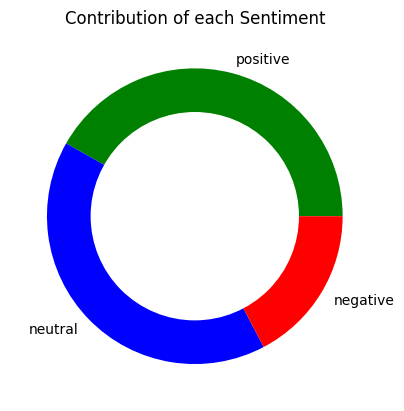

In [ ]:
#Pie Chart for count of Sentiments
piechart = count_sentiments(data, "sentiment")
names = piechart.index
size = piechart["Percentage"]

circle = plt.Circle((0,0),0.7, color="white")
plt.pie(size, labels=names, colors=['green','blue','red'])
pie = plt.gcf()
pie.gca().add_artist(circle)
plt.title("Contribution of each Sentiment")
plt.show()

In [ ]:
#Tweet lengths for each sentiment
data['text_len'] = data['text'].astype(str).apply(len)
data['text_word_count'] = data['text'].apply(lambda x: len(str(x).split()))

In [ ]:
round(pd.DataFrame(data.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,60.89
neutral,36.32
positive,48.01


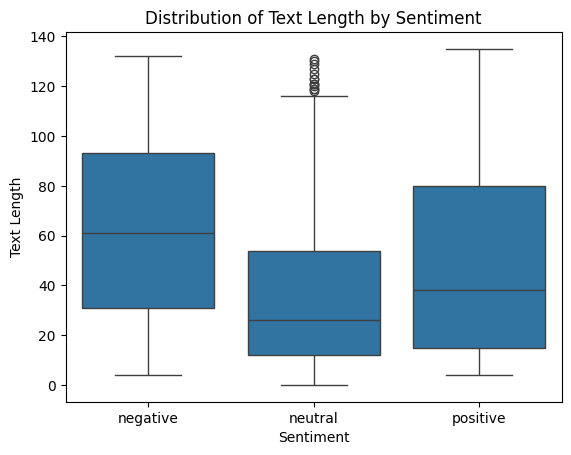

In [ ]:
sns.boxplot(x='sentiment', y='text_len', data=data)

plt.title('Distribution of Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')

plt.show()

In [ ]:
round(pd.DataFrame(data.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,10.57
neutral,6.42
positive,8.39


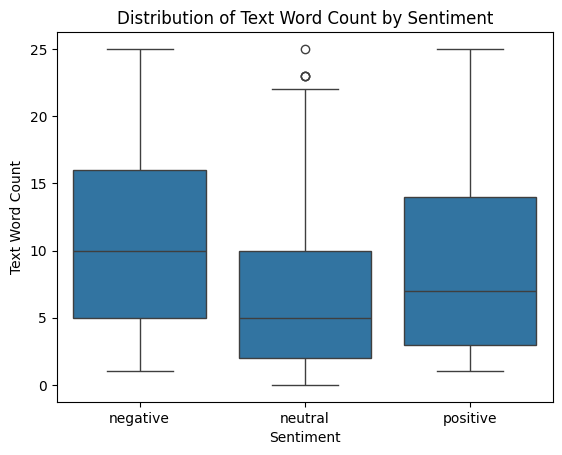

In [ ]:
sns.boxplot(x='sentiment', y='text_word_count', data=data)

# Add title and labels
plt.title('Distribution of Text Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Word Count')

plt.show()

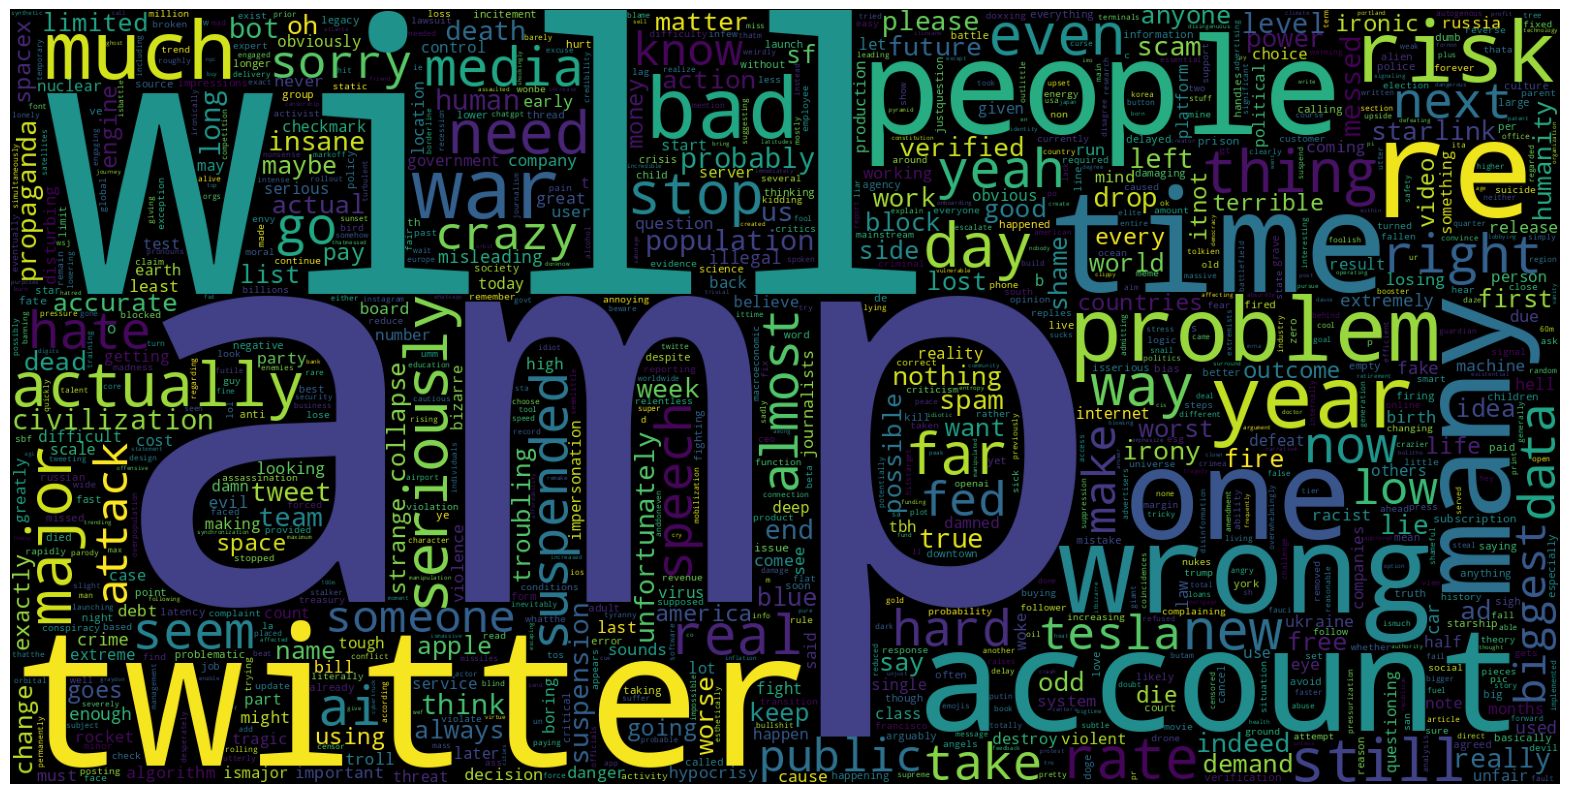

In [ ]:
negative_text = data[data['sentiment'] == 'negative']['text']

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(negative_text))
plt.imshow(wc)
plt.axis('off')
plt.show()

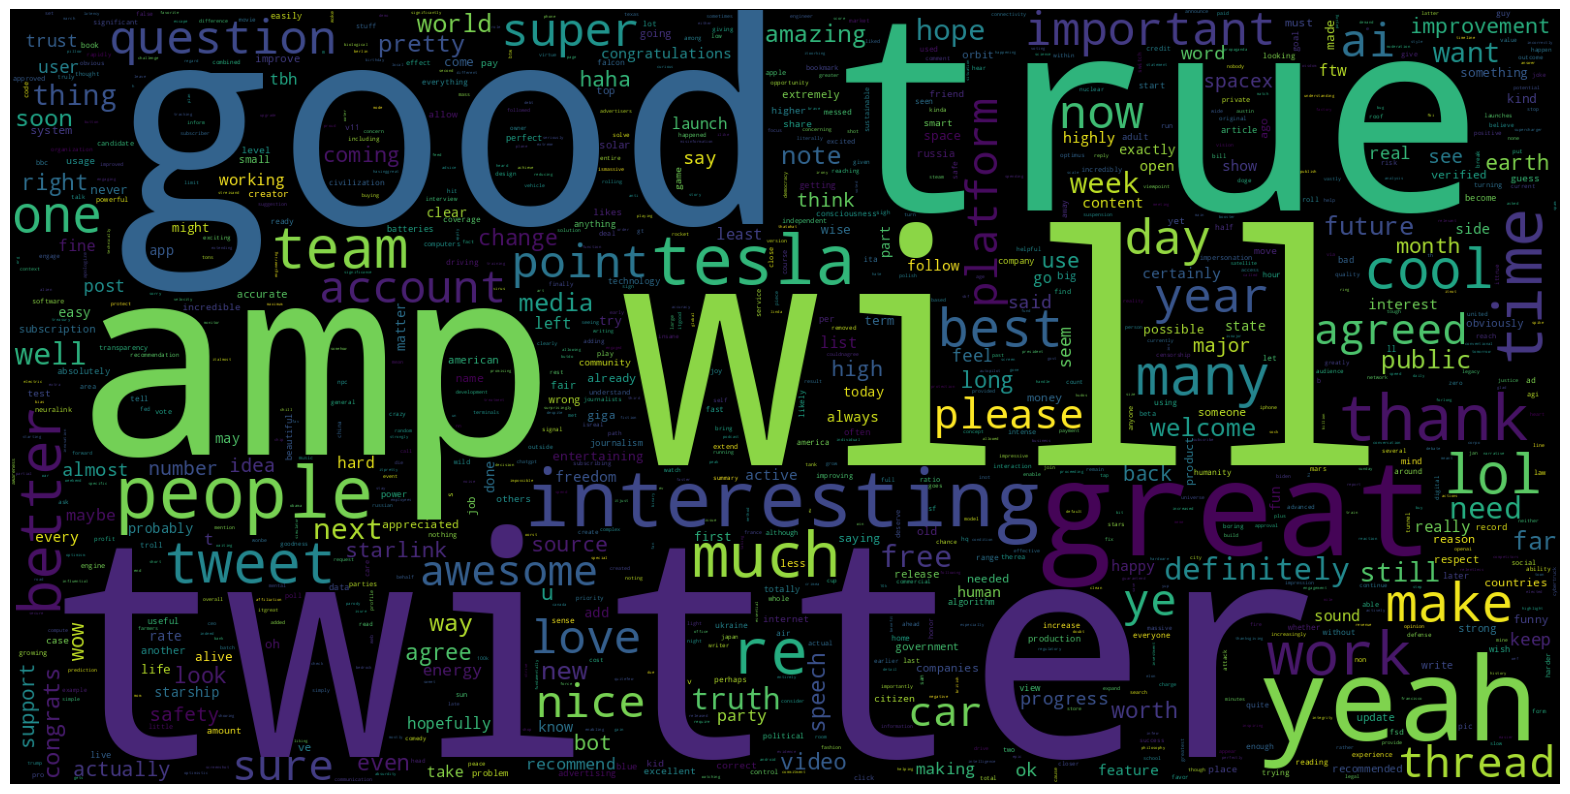

In [ ]:
positive_text = data[data['sentiment'] == 'positive']['text']

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(positive_text))
plt.imshow(wc)
plt.axis('off')
plt.show()

#Model Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text_lemmatized'], data['sentiment'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((4723,), (1181,))

In [ ]:
clf = Pipeline([('tfid',TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_jobs=-1))])

In [ ]:
clf.fit(X_train, y_train)

Pipeline(steps=[('tfid', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_jobs=-1))])

#Model Evaluation

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.75      0.45      0.56       207
     neutral       0.75      0.95      0.84       517
    positive       0.89      0.78      0.83       457

    accuracy                           0.80      1181
   macro avg       0.79      0.73      0.74      1181
weighted avg       0.80      0.80      0.79      1181



#Save the Model

In [ ]:
pickle.dump(clf, open('TwitterSentiment-RF.pkl','wb'))

In [ ]:
clf.predict(['I am Elon Musk and I love aliens'])

array(['positive'], dtype=object)

In [ ]:
from joblib import dump
dump(clf, 'TwitterSentiment-RF.joblib')

['TwitterSentiment-RF.joblib']

#Application - Predicting Sentiments to Live Data



In [ ]:
# scraper = Nitter(log_level = 1)

In [ ]:
# tweets = scraper.get_tweets("jack", mode="term", number=10, language="en")

#search term
#mode - user -> username, hashtag -> for hashtags
#number - number of tweets
#since -> start date
#untill -> end date

In [ ]:
# Create a pretty printer object
# pp = pprint.PrettyPrinter(indent=4)

In [ ]:
# Use the pretty printer to print the data
# pp.pprint(tweets)

In [ ]:
#Look at the key values
# tweets.keys()

In [ ]:
#tweets['tweets'][0]

In [ ]:
#Get user info
#elon_info = scraper.get_profile_info(username="elonmusk")

In [ ]:
#pp.pprint(elon_info)

In [ ]:
def create_tweets_dataset(username, no_of_tweets):
  scraper = Nitter()
  tweets = scraper.get_tweets(username, mode="user", number=no_of_tweets)

  data = {
    'link':[],
    'text':[],
    'user':[],
    'likes':[],
    'quotes':[],
    'retweets':[],
    'comments':[]
  }

  for tweet in tweets['tweets']:
    data['link'].append(tweet['link'])
    data['text'].append(tweet['text'])
    data['user'].append(tweet['user']['name']) #name is inside user
    data['likes'].append(tweet['stats']['likes'])
    data['quotes'].append(tweet['stats']['quotes'])
    data['retweets'].append(tweet['stats']['retweets'])
    data['comments'].append(tweet['stats']['comments'])

  df = pd.DataFrame(data)